In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mpl_col
import matplotlib.cm as cm
from scipy.stats import ks_2samp, mannwhitneyu

In [3]:
import sys

In [4]:
import pop_stats_tools as tools

# Constants

In [5]:
SUPPLEMENT_PATH = "./supp_data/"
RAW_FIGURE_PATH = "./raw_figure/"

In [6]:
VARIANTS = "./data/ExACr0.3.sites.vep.vcf.filtered.tsv"
GENES = "./data/genes.txt"

In [7]:
POPS = ["AFR", "AMR", "SAS", "EAS", "NFE", "FIN"]

In [8]:
COLOR_MAPPING = {"Target": "#A6002C", "target": "#A6002C", "Target genes": "#A6002C",
                 "ADME": "#6C226C", 'other ADME genes': "#6C226C",
                 "Cytochrome": "#2A3FA6", 'Cytochrome P450s': "#2A3FA6",
                 "All genes": "grey"}

# Load drug-related genes

In [9]:
genes = pd.read_csv(GENES, sep="\t", comment="#")

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
pharmacogenes_df = pd.read_csv(SUPPLEMENT_PATH + "pharmacogenes_set.txt", sep="\t")

In [11]:
# targets_approved_drugs.gene_symbol.tolist(), kozyra_genes, fujikura_genes,
target_genes = pharmacogenes_df.loc[pharmacogenes_df["group"].str.contains("target"), "symbol"].tolist()
adme_genes = pharmacogenes_df.loc[pharmacogenes_df["group"].str.contains("ADME") &
                                  ~pharmacogenes_df["subgroup"].str.contains("CYP"), "symbol"].tolist()
cyp_genes = pharmacogenes_df.loc[pharmacogenes_df["group"].str.contains("ADME") &
                                 pharmacogenes_df["subgroup"].str.contains("CYP"), "symbol"].tolist()

# Filter variant set

In [12]:
variants = pd.read_csv(VARIANTS, sep="\t")
variants.columns = [c.replace('CSQ.', '').replace('INFO.', '') for c in variants.columns]

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,81,82,83,95,97,98,100,101,103,104,108,109,110,111,114,115,116,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
filters = [(variants["AN_" + p] > 0) for p in POPS]
variants = tools.multi_filter(variants, filters, np.logical_and)
variants = variants.loc[(variants["AN_Adj"] > 60706)]

In [14]:
tools.add_variud(variants)
variants.drop_duplicates('var_uid', inplace=True)

In [15]:
len(variants)

6872489

In [16]:
len(variants.loc[variants["AC_Adj"] < 2])

3792212

In [17]:
variants = variants.loc[variants["AC_Adj"] >= 1]

In [18]:
len(variants)

6864326

# Variant annotation

## LoF variants (LoFtee HC)

In [19]:
variants_lof = tools.filter_variants(variants,
                                     terms={'LoF': ['HC']})

In [20]:
variants_lof = variants_lof.loc[variants_lof["COMP.AF_Adj"] < 0.5]

In [21]:
print len(variants_lof), "high confidence LoF variants"

207107 high confidence LoF variants


## Functional variants (SIFT u PolyPhen + LoF)

### Rare + common

In [22]:
variants_deleterious = tools.filter_variants(variants,
                                    terms={'PolyPhen': ['damaging'],
                                           'SIFT': ['deleterious']},
                                    conj_fun=np.logical_and)
probably_lof = pd.concat([variants_lof, variants_deleterious]).drop_duplicates()

In [23]:
probably_lof = probably_lof.loc[probably_lof["COMP.AF_Adj"] < 0.5]

In [24]:
print len(probably_lof), "functional variants"

1166720 functional variants


### Allele Frequency >= 0.1 %

In [25]:
probably_lof_common = probably_lof.loc[probably_lof["COMP.AF_Adj"] >= 0.001]

In [26]:
len(probably_lof_common)

15649

In [27]:
print len(probably_lof_common.loc[probably_lof_common["ID"].isnull()]),
print len(probably_lof_common.loc[probably_lof_common.Existing_variation.isnull()])
print len(probably_lof_common.loc[(probably_lof_common["ID"].isnull()) &
                                  (probably_lof_common.Existing_variation.isnull())])

2022 711
566


### Allele Frequency >= 1 %

In [28]:
probably_lof_very_common = probably_lof.loc[probably_lof["COMP.AF_Adj"] >= 0.01]

In [29]:
len(probably_lof_very_common)

3578

### Allele Frequency < 1%

In [30]:
probably_lof_rare = probably_lof.loc[probably_lof["COMP.AF_Adj"] < 0.01]

In [31]:
len(probably_lof_rare)

1163142

### Allele Frequency < 0.1%

In [32]:
probably_lof_very_rare = probably_lof.loc[probably_lof["COMP.AF_Adj"] < 0.001]

In [33]:
len(probably_lof_very_rare)

1151071

# Variants in drug-related genes

In [34]:
variants_pharmacogenes = variants.merge(pharmacogenes_df, left_on="HGNC_ID", right_on="hgnc_id")

In [35]:
len(variants_pharmacogenes)

335758

In [36]:
lof_variants_pharmacogenes = variants_lof.merge(pharmacogenes_df, left_on="HGNC_ID", right_on="hgnc_id")

In [37]:
print lof_variants_pharmacogenes.hgnc_id.nunique(), "drug-related genes with LoF variants"

767 drug-related genes with LoF variants


In [38]:
probably_lof_variants_pharmacogenes = probably_lof.merge(pharmacogenes_df, left_on="HGNC_ID", right_on="hgnc_id")

In [39]:
len(probably_lof_variants_pharmacogenes)

61134

In [40]:
print probably_lof_variants_pharmacogenes.hgnc_id.nunique(), "drug-related genes with functional-variants"

806 drug-related genes with functional-variants


# Allele frequency distributions

## All variants

In [41]:
print len(variants.loc[variants["COMP.AF_Adj"] < 0.001])
print len(variants.loc[variants["COMP.AF_Adj"] < 0.001])/float(len(variants))

6632204
0.966184298356


In [42]:
print len(variants_pharmacogenes.loc[variants_pharmacogenes["COMP.AF_Adj"] < 0.001])
print len(variants_pharmacogenes.loc[variants_pharmacogenes["COMP.AF_Adj"] < 0.001])/float(len(variants_pharmacogenes))

324126
0.965356000453


In [43]:
print len(variants_pharmacogenes.loc[variants_pharmacogenes["COMP.AF_Adj"] < 0.001])
print len(variants_pharmacogenes.loc[variants_pharmacogenes["COMP.AF_Adj"] < 0.001])/float(len(variants_pharmacogenes))


324126
0.965356000453


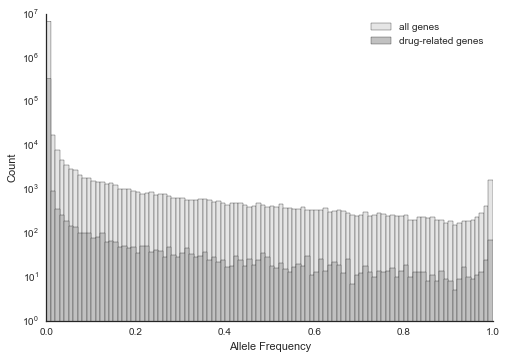

In [45]:
with sns.axes_style('white'):
    ax = variants["COMP.AF_Adj"].plot(kind='hist', bins=100, logy=True, color="#e5e5e5", label='all genes')
    variants_pharmacogenes["COMP.AF_Adj"].plot(kind='hist', bins=100, logy=True, ax=ax, color="#c1c1c1",
                                               label='drug-related genes')
    ax.set_ylabel("Count")
    ax.set_xlabel("Allele Frequency")
    ax.legend()
    sns.despine()
    plt.savefig(RAW_FIGURE_PATH + "AF_distribution_pgx_vs_all.pdf")

In [46]:
ks_2samp(variants["COMP.AF_Adj"].tolist(), variants_pharmacogenes["COMP.AF_Adj"].tolist())

Ks_2sampResult(statistic=0.041629042912377207, pvalue=0.0)

In [47]:
pgx_without_tails = variants_pharmacogenes.loc[variants_pharmacogenes["COMP.AF_Adj"] > 0.01]
all_without_tails = variants.loc[variants["COMP.AF_Adj"] > 0.01]

In [48]:
ks_2samp(all_without_tails["COMP.AF_Adj"].tolist(), pgx_without_tails["COMP.AF_Adj"].tolist())

Ks_2sampResult(statistic=0.012736730973052002, pvalue=0.46715089422132738)

In [49]:
pgx_tail = variants_pharmacogenes.loc[(variants_pharmacogenes["COMP.AF_Adj"] > 0.0) & (variants_pharmacogenes["COMP.AF_Adj"] < 0.01)]
all_tail = variants.loc[(variants["COMP.AF_Adj"] > 0.0) & (variants["COMP.AF_Adj"] < 0.01)]

In [50]:
ks_2samp(all_tail["COMP.AF_Adj"].tolist(), pgx_tail["COMP.AF_Adj"].tolist())

Ks_2sampResult(statistic=0.042361184300041571, pvalue=0.0)

In [51]:
del all_tail
del all_without_tails

## Functional-variants

In [52]:
print len(probably_lof.loc[probably_lof["COMP.AF_Adj"] <= 0.001])
print len(probably_lof.loc[probably_lof["COMP.AF_Adj"] <= 0.001])/float(len(probably_lof))

1151071
0.986587184586


In [53]:
print len(probably_lof_variants_pharmacogenes.loc[probably_lof_variants_pharmacogenes["COMP.AF_Adj"] <= 0.001])
print len(probably_lof_variants_pharmacogenes.loc[probably_lof_variants_pharmacogenes["COMP.AF_Adj"] <= 0.001])/float(len(probably_lof_variants_pharmacogenes))

60356
0.987273857428


In [54]:
ks_2samp(probably_lof["COMP.AF_Adj"].tolist(), probably_lof_variants_pharmacogenes["COMP.AF_Adj"].tolist())

Ks_2sampResult(statistic=0.052306340173912891, pvalue=1.3074173401735494e-138)

## Functional-variants vs all variants

In [55]:
variants_pharmacogenes_maf = variants_pharmacogenes.loc[variants_pharmacogenes["COMP.AF_Adj"] < 0.5]

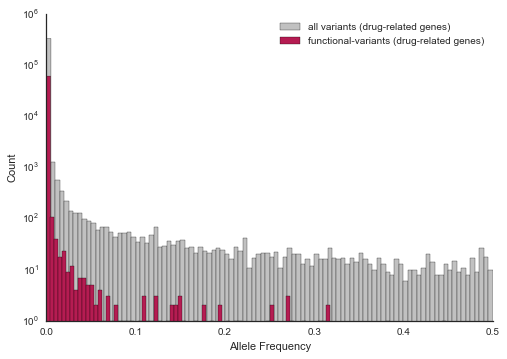

In [56]:
with sns.axes_style("white"):
    ax = variants_pharmacogenes_maf["COMP.AF_Adj"].plot(kind='hist', bins=100, logy=True, color="#c1c1c1",
                                                    label='all variants (drug-related genes)')
    probably_lof_variants_pharmacogenes["COMP.AF_Adj"].plot(kind='hist', bins=100, logy=True, ax=ax,
                                                            color="#B51C52",
                                                            label='functional-variants (drug-related genes)')
    ax.set_ylabel("Count")
    ax.set_xlabel("Allele Frequency")
    ax.legend()
    sns.despine()
    plt.savefig(RAW_FIGURE_PATH + "AF_distribution_functional_vs_all_pgx.pdf")

In [57]:
ks_2samp(variants_pharmacogenes_maf["COMP.AF_Adj"].tolist(), probably_lof_variants_pharmacogenes["COMP.AF_Adj"].tolist())

Ks_2sampResult(statistic=0.11894664924080078, pvalue=0.0)

In [58]:
mannwhitneyu(variants_pharmacogenes_maf["COMP.AF_Adj"].tolist(),
             probably_lof_variants_pharmacogenes["COMP.AF_Adj"].tolist())

MannwhitneyuResult(statistic=11637444655.0, pvalue=0.0)

# Aggregate by gene

In [59]:
nonsense= ['transcript_ablation', 'splice_acceptor_variant',
           'splice_donor_variant', 'stop_gained',
           'frameshift_variant', 'stop_lost',
           'start_lost', 'initiator_codon_variant']
aggregations = {
    'var_uid': {
        'unique_variants': lambda x: len(set(x))
    },
    'Existing_variation': {
        'count': lambda x: len(set(x)),
        'ids': lambda x: ','.join([y for y in x if str(y) != 'nan'])
    },
    'SIFT': {
        'num_deleterious': lambda x: len([y for y in x if 'deleterious' in str(y)]),
        'num_tolerated': lambda x: len([y for y in x if 'tolerated' in str(y)]),
        'num_missing': lambda x: len([y for y in x if str(y) == 'nan'])
    },
    'PolyPhen': {
        'num_deleterious': lambda x: len([y for y in x if 'damaging' in str(y)]),
        'num_tolerated': lambda x: len([y for y in x if 'benign' in str(y)]),
        'num_missing': lambda x: len([y for y in x if str(y) == 'nan'])
    },
    'Consequence': {
        'num_missense': lambda x: len([y for y in x
                                       if 'missense_variant' in str(y) and not any(c in str(y) for c in nonsense)]),
        'num_nonsense': lambda x: len([y for y in x if any(c in str(y) for c in nonsense)]),
    },
    'COMP.AF_Adj': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    },
    'COMP.AF_NFE': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    },
    'COMP.AF_FIN': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    },
    'COMP.AF_EAS': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    },
    'COMP.AF_SAS': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    },
    'COMP.AF_AFR': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    },
    'COMP.AF_AMR': {
        'common': lambda x: len([y for y in x if y >= 0.001]),
        'very_rare': lambda x: len([y for y in x if y < 0.001]),
    }
}
col_order = ['var_uid', 'Existing_variation', 'Consequence', 'SIFT', 'PolyPhen', 'COMP.AF_Adj',
             'COMP.AF_AFR', 'COMP.AF_AMR', 'COMP.AF_SAS', 'COMP.AF_EAS', 'COMP.AF_NFE', 'COMP.AF_FIN',]

In [60]:
variants_by_gene = variants.groupby(['SYMBOL', 'HGNC_ID']).agg(aggregations)[col_order]

In [61]:
len(variants_by_gene)

20521

In [62]:
probably_lof_by_gene = probably_lof.groupby(['SYMBOL', 'HGNC_ID']).agg(aggregations)[col_order]

In [63]:
lof_by_gene = variants_lof.groupby(['SYMBOL', 'HGNC_ID']).agg(aggregations)[col_order]

# Fraction of variant types

In [64]:
def calculate_fraction_rare(by_gene, target_genes, adme_genes, cyp_genes, genes_df):
    ve = by_gene.reset_index()
    
    variants_by_all = ve.merge(genes_df, left_on="SYMBOL", right_on="symbol")
    variants_by_all["normalized_unique_variants"] = variants_by_all[('var_uid', 'unique_variants')] / variants_by_all['length']
    variants_by_all["percent_common"] = variants_by_all[("COMP.AF_Adj", "common")] / variants_by_all[("var_uid", "unique_variants")]
    variants_by_all["percent_very_rare"] = variants_by_all[("COMP.AF_Adj", "very_rare")] / variants_by_all[("var_uid", "unique_variants")]
    
    variants_by_target = ve.loc[ve.SYMBOL.isin(target_genes)]
    variants_by_target = variants_by_target.merge(genes_df, left_on="SYMBOL", right_on="symbol")
    variants_by_target["normalized_unique_variants"] = variants_by_target[('var_uid', 'unique_variants')] / variants_by_target['length']
    variants_by_target["percent_common"] = variants_by_target[("COMP.AF_Adj", "common")] / variants_by_target[("var_uid", "unique_variants")]
    variants_by_target["percent_very_rare"] = variants_by_target[("COMP.AF_Adj", "very_rare")] / variants_by_target[("var_uid", "unique_variants")]

    variants_by_pharmacogene = ve.loc[ve.SYMBOL.isin(adme_genes)]
    variants_by_pharmacogene = variants_by_pharmacogene.merge(genes_df, left_on="SYMBOL", right_on="symbol")
    variants_by_pharmacogene["normalized_unique_variants"] = variants_by_pharmacogene[('var_uid', 'unique_variants')] / variants_by_pharmacogene['length']
    variants_by_pharmacogene["percent_common"] = variants_by_pharmacogene[("COMP.AF_Adj", "common")] / variants_by_pharmacogene[("var_uid", "unique_variants")]
    variants_by_pharmacogene["percent_very_rare"] = variants_by_pharmacogene[("COMP.AF_Adj", "very_rare")] / variants_by_pharmacogene[("var_uid", "unique_variants")]

    cyp_variants = ve.loc[ve.SYMBOL.isin(cyp_genes)]
    cyp_variants = cyp_variants.merge(genes_df, left_on="SYMBOL", right_on="symbol")
    cyp_variants["normalized_unique_variants"] = cyp_variants[('var_uid', 'unique_variants')] / cyp_variants['length']
    cyp_variants["percent_common"] = cyp_variants[("COMP.AF_Adj", "common")] / cyp_variants[("var_uid", "unique_variants")]
    cyp_variants["percent_very_rare"] = cyp_variants[("COMP.AF_Adj", "very_rare")] / cyp_variants[("var_uid", "unique_variants")]
    
    variants_by_all["group"] = "All genes"
    variants_by_target["group"] = "Target genes"
    cyp_variants["group"] = "Cytochrome P450s"
    variants_by_pharmacogene["group"] = "other ADME genes"
    
    
    all_groups = variants_by_all.append(variants_by_target).append(cyp_variants).append(variants_by_pharmacogene)
    
    return variants_by_all, variants_by_target, variants_by_pharmacogene, cyp_variants, all_groups

In [65]:
ve = variants_by_gene.reset_index()

## Fraction of rare variants

### All variants

In [66]:
variants_by_all, variants_by_target, variants_by_pharmacogene, variants_by_cyp, all_groups = calculate_fraction_rare(
    variants_by_gene, target_genes, adme_genes, cyp_genes, genes[["symbol", 'length']])

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


### Functional-variants

In [67]:
prob_lof_variants_by_all, prob_lof_variants_by_target, prob_lof_variants_by_pharmacogene, prob_lof_variants_by_cyp, all_groups_prob_lof = \
    calculate_fraction_rare(probably_lof_by_gene,  target_genes, adme_genes, cyp_genes, genes[["symbol", 'length']])

### LoF variants

In [68]:
lof_variants_by_all, lof_variants_by_target, lof_variants_by_pharmacogene, lof_variants_by_cyp, all_groups_lof = calculate_fraction_rare(
    lof_by_gene,  target_genes, adme_genes, cyp_genes, genes[["symbol", 'length']])

## Fraction novel variants

### All variants

In [69]:
all_groups["frac_novel"] = 1 - all_groups[("Existing_variation", "count")]/all_groups[("var_uid", "unique_variants")]

### Functional variants

In [70]:
all_groups_prob_lof["frac_novel"] = 1 - all_groups_prob_lof[("Existing_variation", "count")]/all_groups_prob_lof[("var_uid", "unique_variants")]

## Fraction functional/LoF in all variants

### Functional-variants

In [71]:
all_groups_frac = all_groups[[('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants'), ('group')]].merge(
    all_groups_prob_lof[[('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants')]],
    on=[('SYMBOL', ''), ('HGNC_ID', '')], suffixes=["_all", "_lof"])

In [72]:
all_groups_frac["fraction_lof"] = all_groups_frac["('var_uid', 'unique_variants')_lof"] / all_groups_frac["('var_uid', 'unique_variants')_all"]
all_groups_frac.drop_duplicates(inplace=True)

### LoF variants

In [73]:
all_groups_lof_frac = all_groups[[('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants'), ('group')]].merge(
    all_groups_lof[[('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants')]],
    on=[('SYMBOL', ''), ('HGNC_ID', '')], suffixes=["_all", "_lof"])

In [74]:
all_groups_lof_frac["fraction_lof"] = all_groups_lof_frac["('var_uid', 'unique_variants')_lof"] / all_groups_lof_frac["('var_uid', 'unique_variants')_all"]
all_groups_lof_frac.drop_duplicates(inplace=True)

### Figure

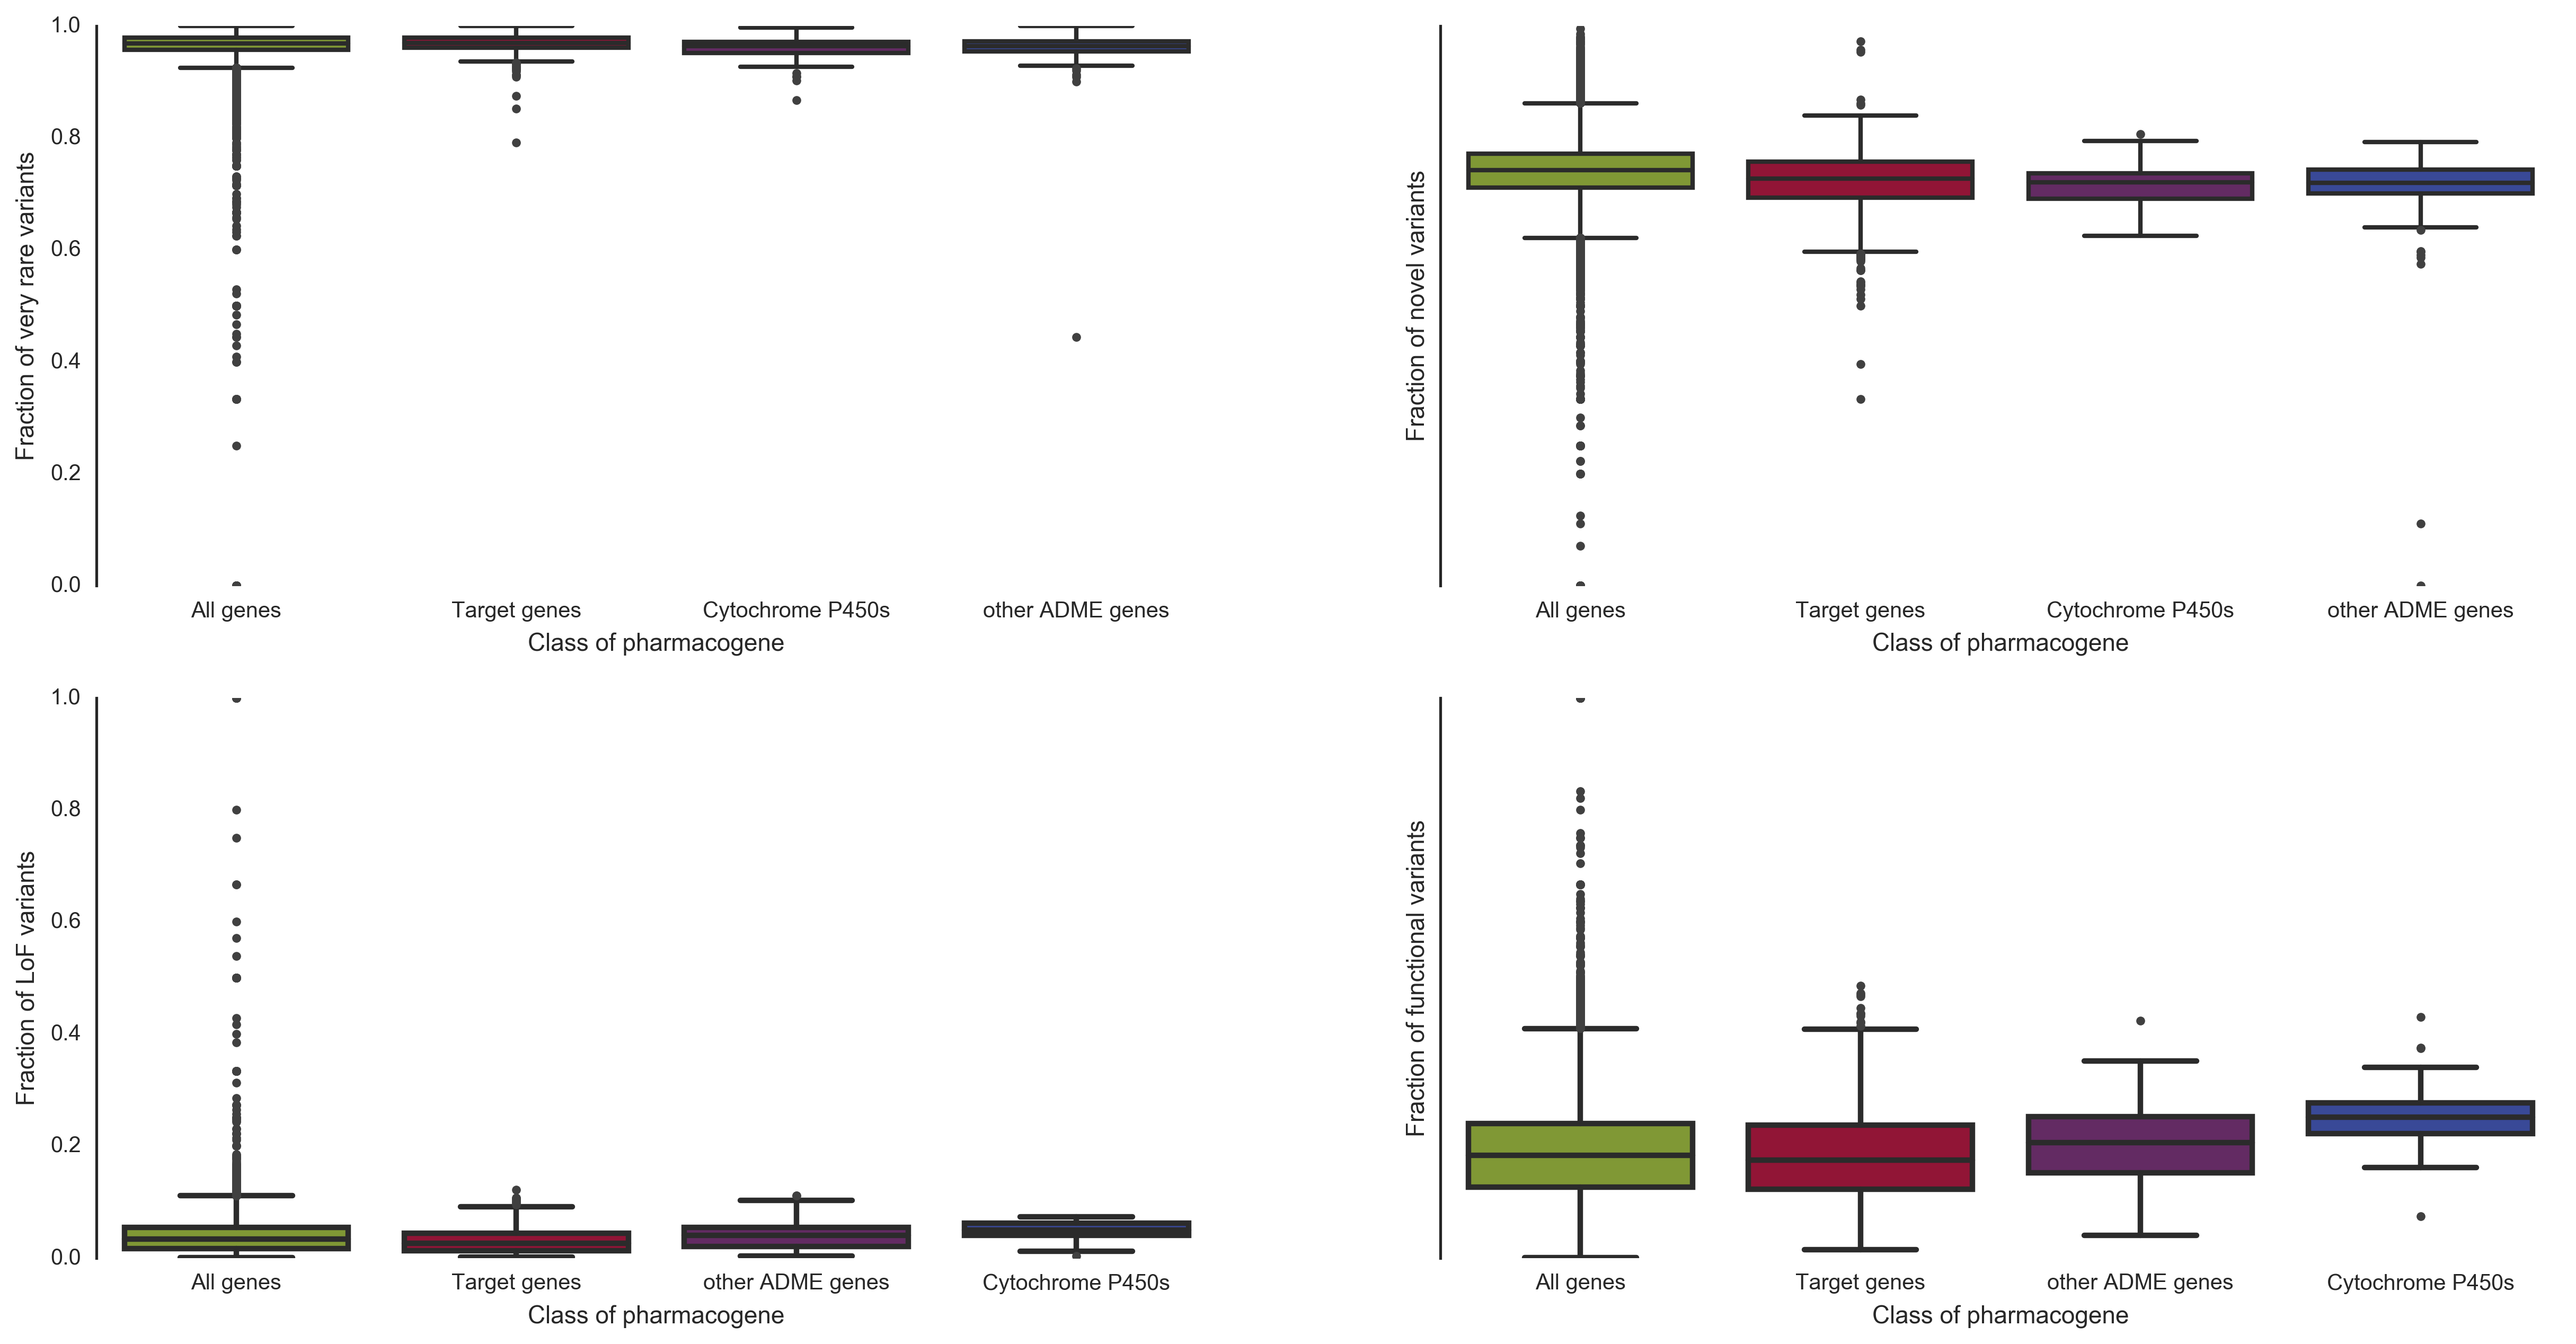

In [75]:
with sns.axes_style("white"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10), dpi=300, sharey=True)
    flierprops = dict(marker='o', markersize=4, markerfacecolor='.25')

    bp = sns.boxplot(x="group", y="percent_very_rare", data=all_groups,
                palette=["#88A825", "#A6002C", "#6C226C", "#2A3FA6"], ax=ax1,
                flierprops=flierprops, linewidth=2.0)
    ax1.set_ylim(0.0, 1.0)
    ax1.set_xlabel("Class of pharmacogene")
    ax1.set_ylabel("Fraction of very rare variants")
    
    
    sns.boxplot(x="group", y="frac_novel", data=all_groups,
                palette=["#88A825", "#A6002C", "#6C226C", "#2A3FA6"], ax=ax2,
                flierprops=flierprops, linewidth=2.0)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_xlabel("Class of pharmacogene")
    ax2.set_ylabel("Fraction of novel variants")
    
    sns.boxplot(y="fraction_lof", x="group", ax=ax3, data=all_groups_lof_frac, 
                palette=["#88A825", "#A6002C", "#6C226C", "#2A3FA6"], flierprops=flierprops,
                linewidth=2.5);
    sns.despine(top=True, right=True, bottom=True)
    ax3.set_ylim(0.0, 1.0)
    ax3.set_ylabel("Fraction of LoF variants")
    ax3.set_xlabel("Class of pharmacogene")
    
    sns.boxplot(y="fraction_lof", x="group", ax=ax4, data=all_groups_frac,
                palette=["#88A825", "#A6002C", "#6C226C", "#2A3FA6"], flierprops=flierprops,
                linewidth=2.5);
    sns.despine(top=True, right=True, bottom=True)
    ax4.set_ylim(0.0, 1.0)
    ax4.set_ylabel("Fraction of functional variants")
    ax4.set_xlabel("Class of pharmacogene")
    

plt.savefig(RAW_FIGURE_PATH + "Fractions_novel_rare_functional_detailed.pdf",
            dpi=300)

## Include full variant distribution

In [76]:
def calculate_fraction_rare2(by_gene, target_genes, genes_df):
    ve = by_gene.reset_index()
    
    variants_by_all = ve.merge(genes_df, left_on="SYMBOL", right_on="symbol")
    variants_by_all["normalized_unique_variants"] = variants_by_all[('var_uid', 'unique_variants')] / variants_by_all['length']
    variants_by_all["percent_common"] = variants_by_all[("COMP.AF_Adj", "common")] / variants_by_all[("var_uid", "unique_variants")]
    variants_by_all["percent_very_rare"] = variants_by_all[("COMP.AF_Adj", "very_rare")] / variants_by_all[("var_uid", "unique_variants")]
    
    variants_by_target = ve.loc[ve.SYMBOL.isin(target_genes)]
    variants_by_target = variants_by_target.merge(genes_df, left_on="SYMBOL", right_on="symbol")
    variants_by_target["normalized_unique_variants"] = variants_by_target[('var_uid', 'unique_variants')] / variants_by_target['length']
    variants_by_target["percent_common"] = variants_by_target[("COMP.AF_Adj", "common")] / variants_by_target[("var_uid", "unique_variants")]
    variants_by_target["percent_very_rare"] = variants_by_target[("COMP.AF_Adj", "very_rare")] / variants_by_target[("var_uid", "unique_variants")]

    variants_by_all["group"] = "All genes"
    variants_by_target["group"] = "Pharmacogenes"
    
    all_groups = variants_by_all.append(variants_by_target)
    
    return variants_by_all, variants_by_target, all_groups

In [77]:
variants_by_all_pg, variants_by_pharmacogene, all_groups_pg = calculate_fraction_rare2(
    variants_by_gene, pharmacogenes_df.symbol.tolist(),
    genes[["symbol", 'length']])

lof_variants_by_all_pg, lof_variants_by_pharmacogene, all_groups_lof_pg = calculate_fraction_rare2(
    lof_by_gene, pharmacogenes_df.symbol.tolist(),
    genes[["symbol", 'length']])

lof_variants_by_all_pg, prob_lof_variants_by_pharmacogene, all_groups_prob_lof_pg = \
    calculate_fraction_rare2(probably_lof_by_gene, pharmacogenes_df.symbol.tolist(),
                            genes[["symbol", 'length']])

In [78]:
all_groups_pg["frac_novel"] = 1 - all_groups_pg[("Existing_variation", "count")]/all_groups_pg[("var_uid", "unique_variants")]
all_groups_prob_lof_pg["frac_novel"] = 1 - all_groups_prob_lof_pg[("Existing_variation", "count")]/all_groups_prob_lof_pg[("var_uid", "unique_variants")]

In [79]:
all_groups_frac_pg = all_groups_pg[[('SYMBOL', ''), ('HGNC_ID', ''),
                                    ('var_uid', 'unique_variants'), ('group')]].merge(
    all_groups_prob_lof_pg[[('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants')]],
    on=[('SYMBOL', ''), ('HGNC_ID', '')], suffixes=["_all", "_lof"])
all_groups_frac_pg["fraction_lof"] = all_groups_frac_pg["('var_uid', 'unique_variants')_lof"] / all_groups_frac_pg["('var_uid', 'unique_variants')_all"]
all_groups_frac_pg.drop_duplicates(inplace=True)


all_groups_lof_frac_pg = all_groups_pg[[('SYMBOL', ''), ('HGNC_ID', ''),
                                        ('var_uid', 'unique_variants'), ('group')]].merge(
    all_groups_lof_pg[[('SYMBOL', ''), ('HGNC_ID', ''), ('var_uid', 'unique_variants')]],
    on=[('SYMBOL', ''), ('HGNC_ID', '')], suffixes=["_all", "_lof"])
all_groups_lof_frac_pg["fraction_lof"] = all_groups_lof_frac_pg["('var_uid', 'unique_variants')_lof"] / all_groups_lof_frac_pg["('var_uid', 'unique_variants')_all"]
all_groups_lof_frac_pg.drop_duplicates(inplace=True)

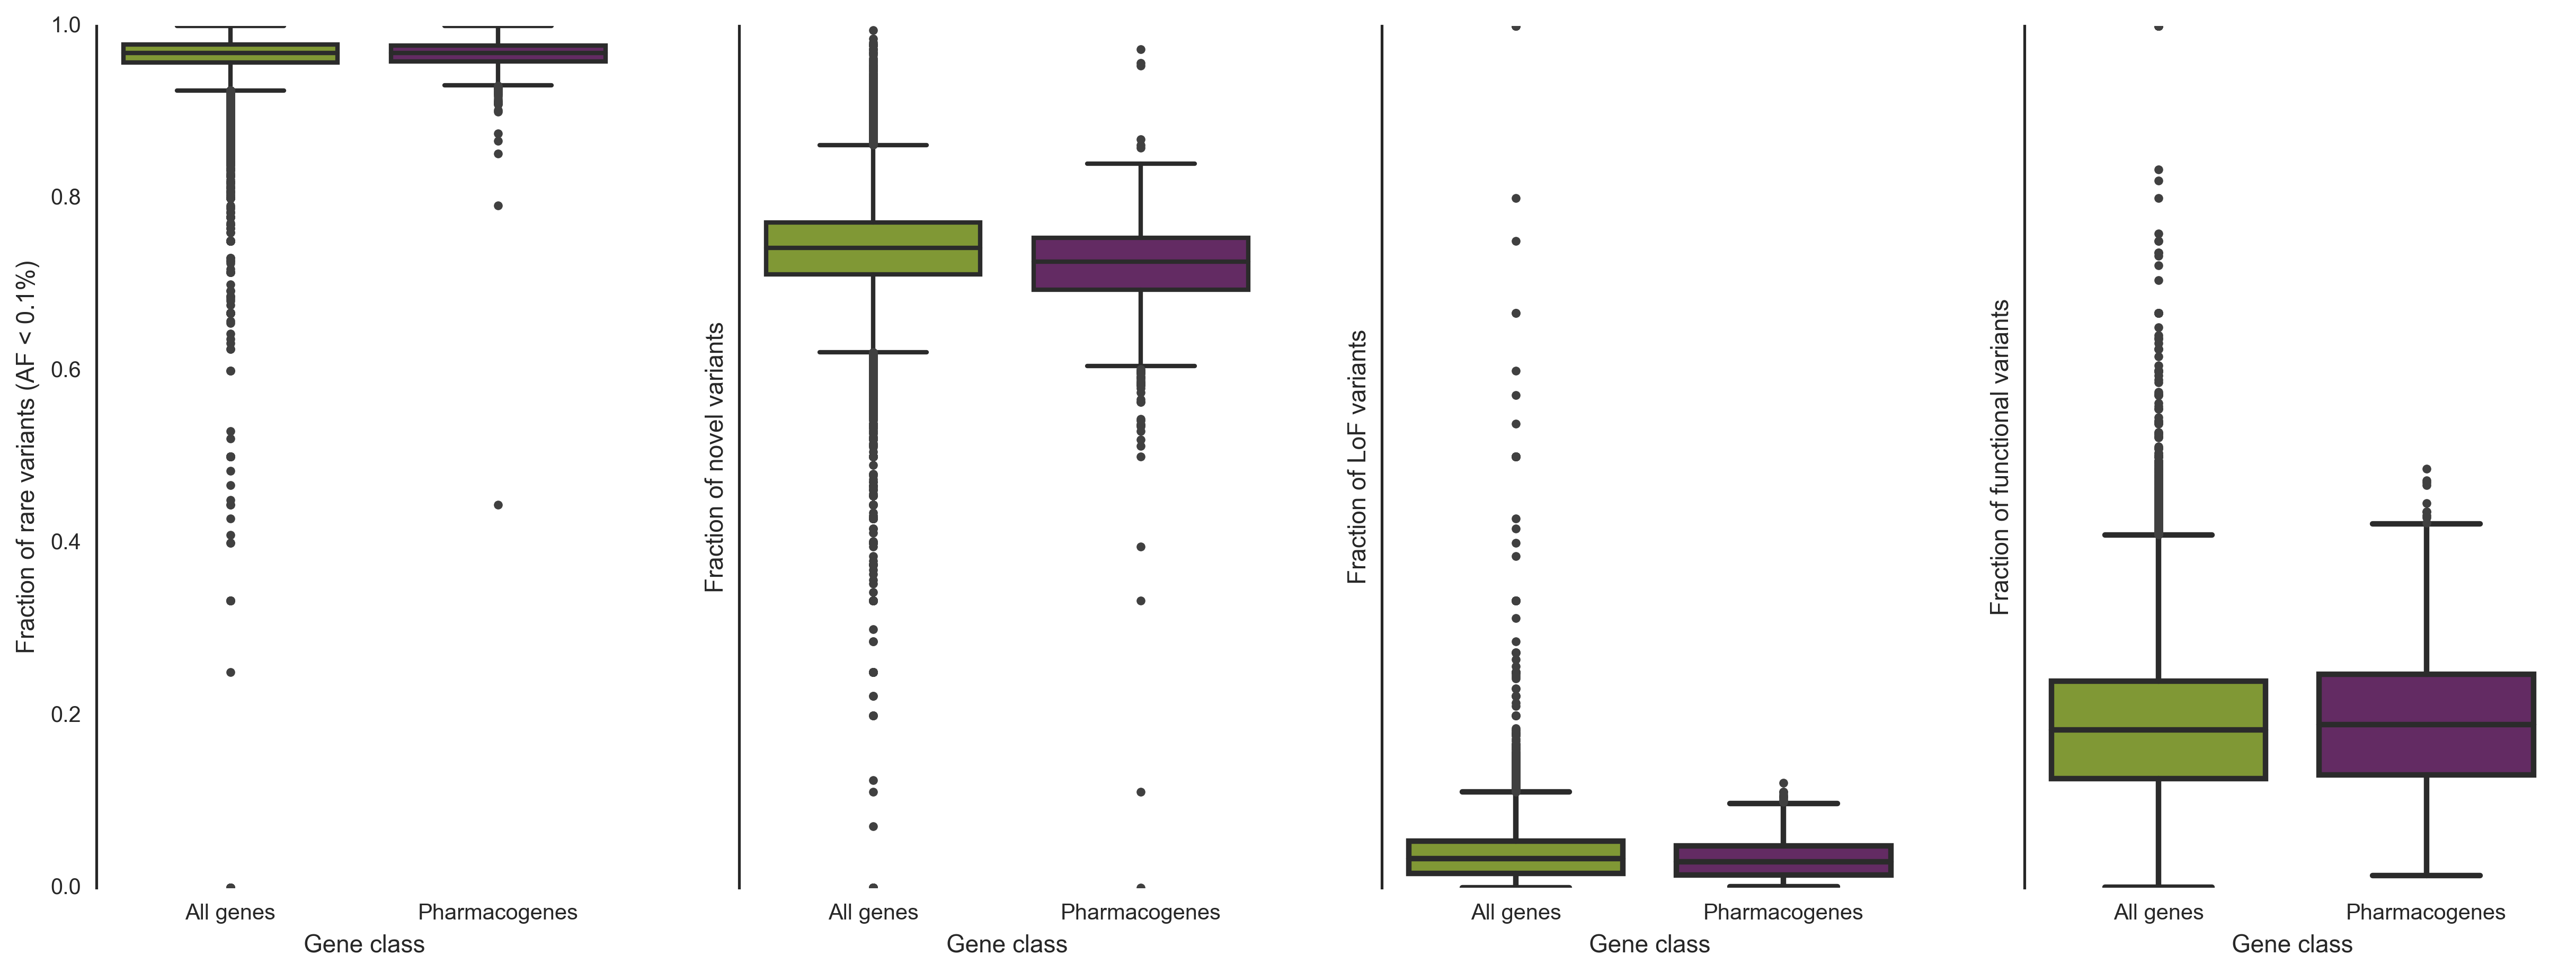

In [80]:
with sns.axes_style("white"):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7), dpi=300, sharey=True)
    flierprops = dict(marker='o', markersize=4, markerfacecolor='.25')

    bp = sns.boxplot(x="group", y="percent_very_rare", data=all_groups_pg,
                palette=["#88A825", "#6C226C", "#2A3FA6"], ax=ax1,
                flierprops=flierprops, linewidth=2.0)
    ax1.set_ylim(0.0, 1.0)
    ax1.set_xlabel("Gene class")
    ax1.set_ylabel("Fraction of rare variants (AF < 0.1%)")
    
    
    sns.boxplot(x="group", y="frac_novel", data=all_groups_pg,
                palette=["#88A825", "#6C226C", "#2A3FA6"], ax=ax2,
                flierprops=flierprops, linewidth=2.0)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_xlabel("Gene class")
    ax2.set_ylabel("Fraction of novel variants")
    
    sns.boxplot(y="fraction_lof", x="group", ax=ax3, data=all_groups_lof_frac_pg, 
                palette=["#88A825", "#6C226C", "#2A3FA6"], flierprops=flierprops,
                linewidth=2.5);
    sns.despine(top=True, right=True, bottom=True)
    ax3.set_ylim(0.0, 1.0)
    ax3.set_ylabel("Fraction of LoF variants")
    ax3.set_xlabel("Gene class")
    
    sns.boxplot(y="fraction_lof", x="group", ax=ax4, data=all_groups_frac_pg,
                palette=["#88A825", "#6C226C", "#2A3FA6"], flierprops=flierprops,
                linewidth=2.5);
    sns.despine(top=True, right=True, bottom=True)
    ax4.set_ylim(0.0, 1.0)
    ax4.set_ylabel("Fraction of functional variants")
    ax4.set_xlabel("Gene class")
    

plt.savefig(RAW_FIGURE_PATH + "Fractions_novel_rare_functional.pdf",
            dpi=300)

# Variability based on length

In [81]:
supplementary_gene_hotspots_all = all_groups_prob_lof.rename(columns={
        ("COMP.AF_Adj", "common"): "#common functional",
        ("var_uid", "unique_variants"): "#total functional"})\
    [["symbol", "group", "length", "#total functional", "#common functional", "normalized_unique_variants"]]\
    .groupby(["symbol", "length", "#total functional", "#common functional", "normalized_unique_variants"])\
    .agg({"group": lambda x: ", ".join(sorted(x))})\
    .reset_index()\
    .sort_values(by=["normalized_unique_variants"], ascending=False)

In [82]:
supplementary_gene_hotspots = all_groups_prob_lof.rename(columns={
        ("COMP.AF_Adj", "common"): "#common functional",
        ("var_uid", "unique_variants"): "#total functional"})\
    [["symbol", "group", "length", "#total functional", "#common functional", "normalized_unique_variants"]]\
    .loc[all_groups_prob_lof["group"] != "All genes"]\
    .groupby(["symbol", "length", "#total functional", "#common functional", "normalized_unique_variants"])\
    .agg({"group": lambda x: ", ".join(sorted(x))})\
    .reset_index()\
    .sort_values(by=["normalized_unique_variants"], ascending=False)



## Non-synonymous variants

### Including variants in all genes

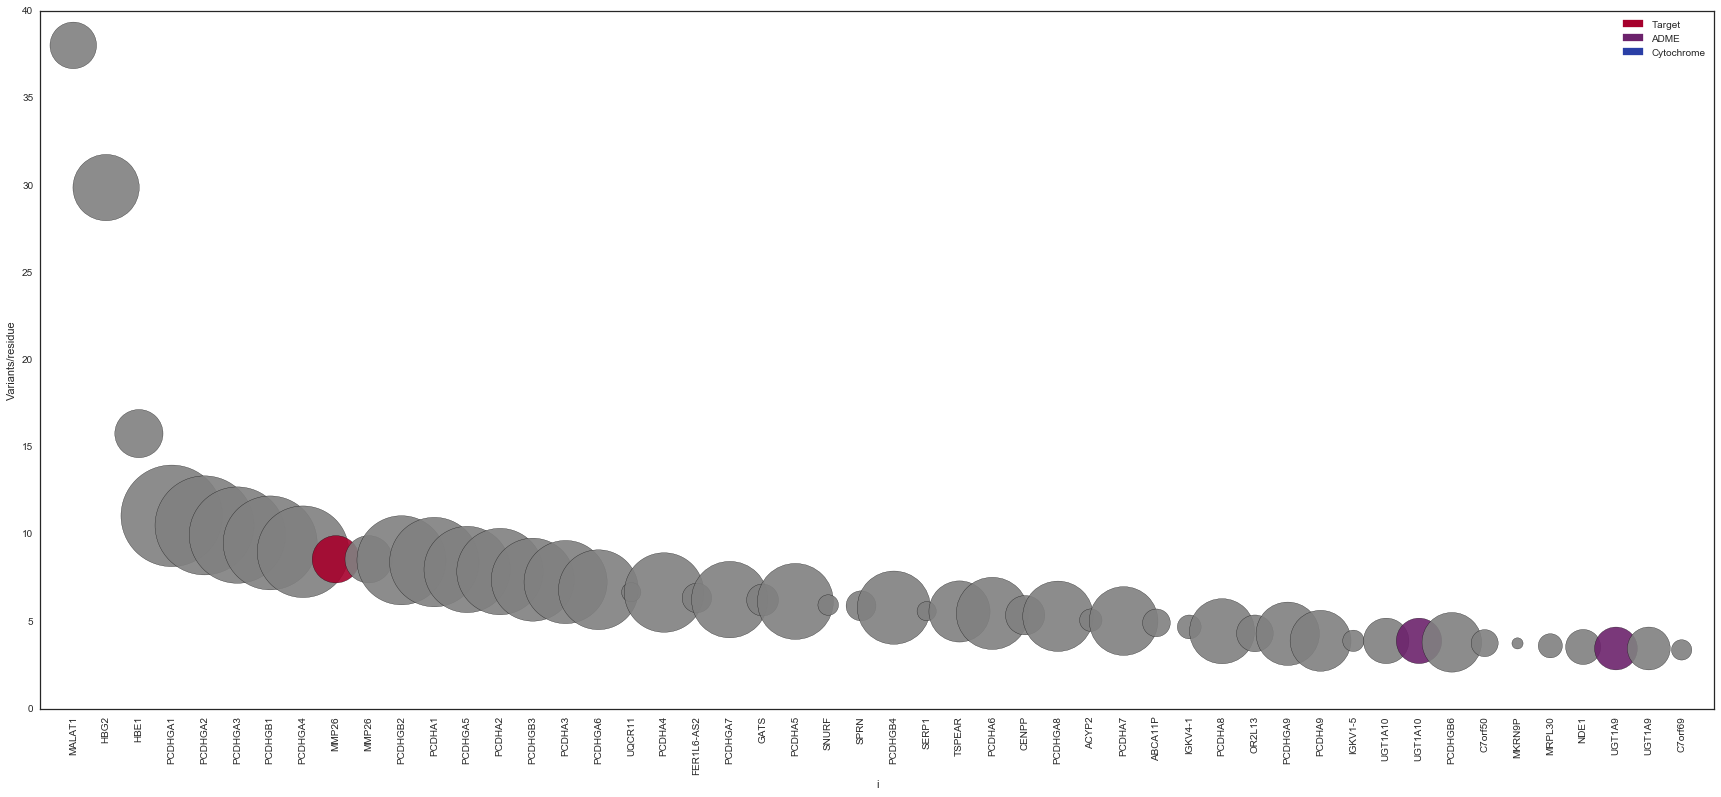

In [83]:
with sns.axes_style("white"):
    subset_all = all_groups.sort_values(by=["normalized_unique_variants"], ascending=False)[:50]
    subset_all.loc[:, 'i'] = subset_all.reset_index().index

    fig, ax = plt.subplots(1, 1, figsize=(30, 12.5))

    subset_all.plot('i', 'normalized_unique_variants',
                    kind='scatter',
                    marker='o',
                    ax=ax,
                    s=subset_all[('var_uid', 'unique_variants')],
                    c=[COLOR_MAPPING[x] for x in subset_all[('group')]],
                    alpha=0.9)

    ax.set_xlim(-1, len(subset_all))
#     ax.set_ylim(0.0, 0.2)
    plt.xticks(subset_all['i'],
               [str(i) for i in subset_all[('SYMBOL', '')]],
               rotation='vertical')
    
    t = mpatches.Patch(color="#A6002C", label='Target')
    a = mpatches.Patch(color="#6C226C", label='ADME')
    c = mpatches.Patch(color="#2A3FA6", label='Cytochrome')
    ax.set_ylabel("Variants/residue")
    plt.legend(handles=[t, a, c])

#### Functional-variants only

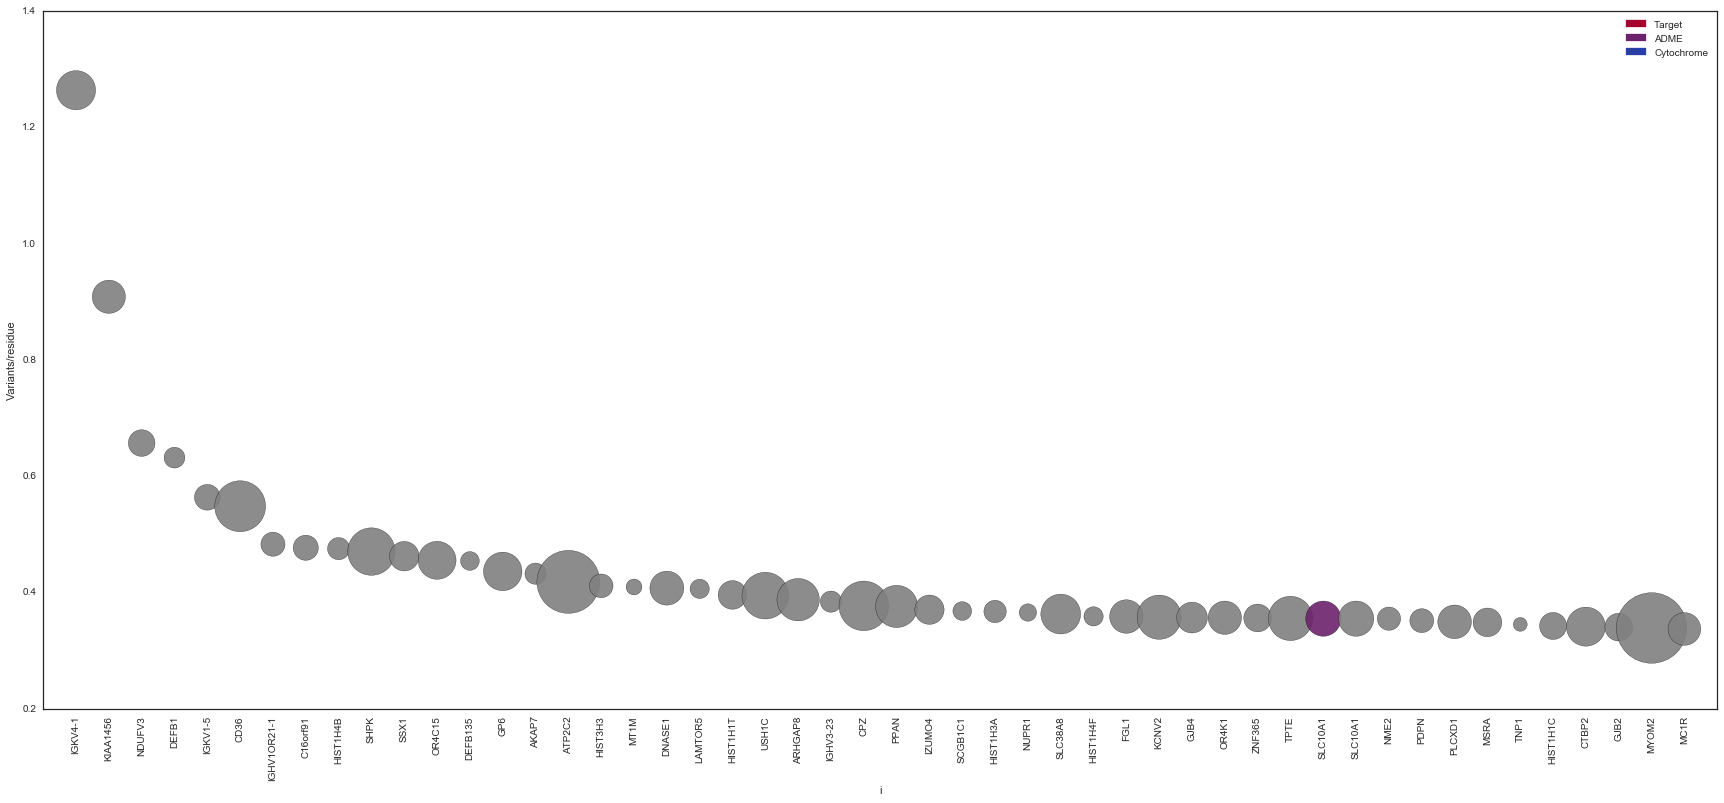

In [84]:
with sns.axes_style("white"):
    subset_all = all_groups_prob_lof.sort_values(by=["normalized_unique_variants"], ascending=False)[:50]
    subset_all.loc[:, 'i'] = subset_all.reset_index().index

    fig, ax = plt.subplots(1, 1, figsize=(30, 12.5))

    subset_all.plot('i', 'normalized_unique_variants',
                    kind='scatter',
                    marker='o',
                    ax=ax,
                    s=subset_all[('var_uid', 'unique_variants')] * 10,
                    c=[COLOR_MAPPING[x] for x in subset_all[('group')]],
                    alpha=0.9)

    ax.set_xlim(-1, len(subset_all))
    plt.xticks(subset_all['i'],
               [str(i) for i in subset_all[('SYMBOL', '')]],
               rotation='vertical')
    
    t = mpatches.Patch(color="#A6002C", label='Target')
    a = mpatches.Patch(color="#6C226C", label='ADME')
    c = mpatches.Patch(color="#2A3FA6", label='Cytochrome')
    plt.legend(handles=[t, a, c])
    ax.set_ylabel("Variants/residue")
#     sns.despine(top=True, right=True, bottom=True)

### Drug-related genes only

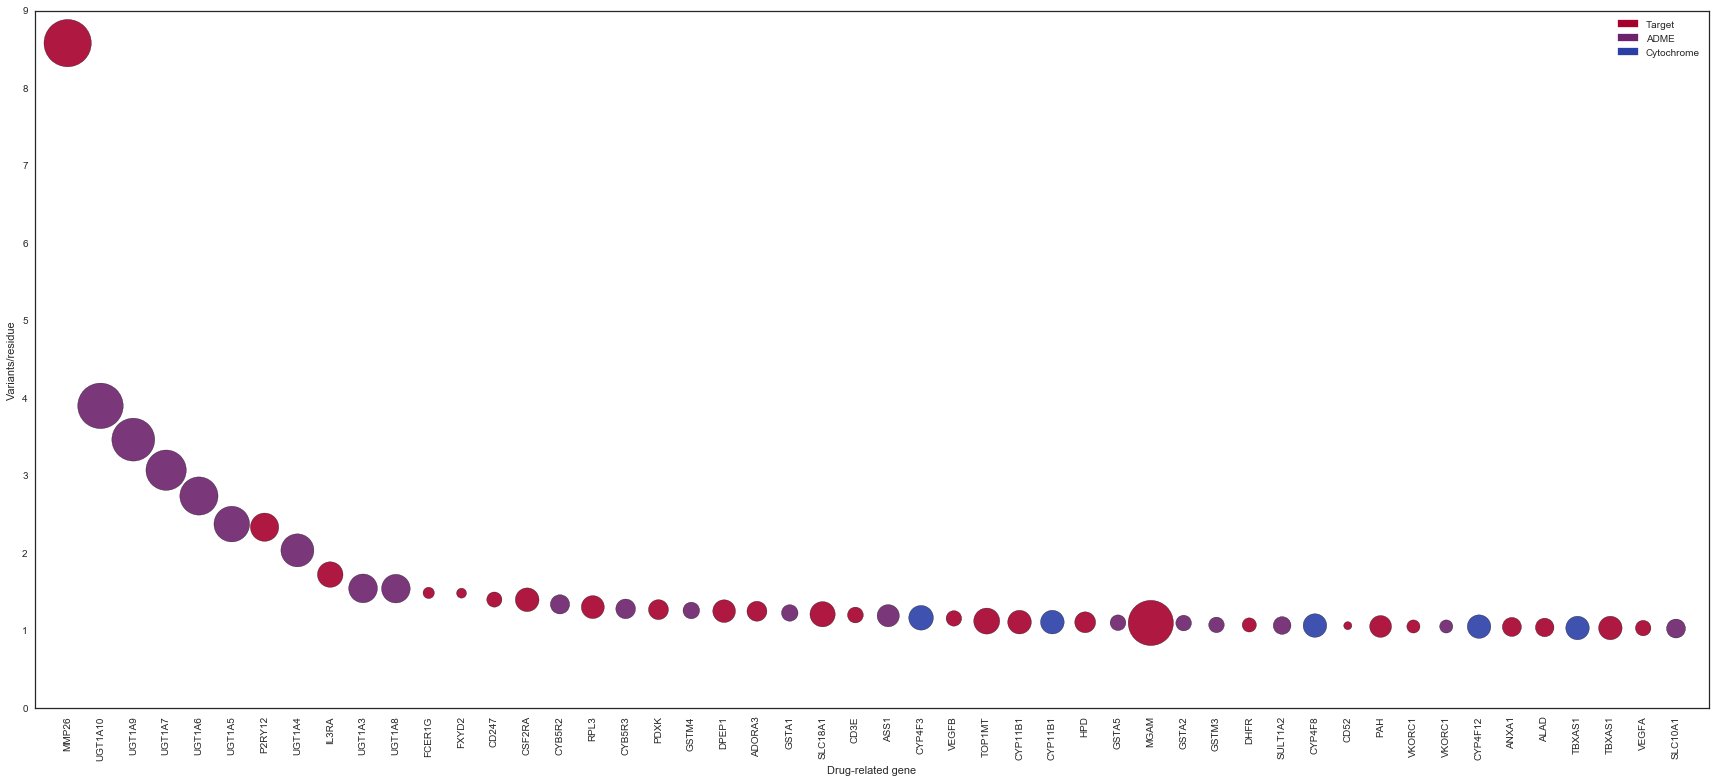

In [85]:
with sns.axes_style("white"):
    subset_all = all_groups.loc[all_groups["group"] != "All genes"].sort_values(by=["normalized_unique_variants"], ascending=False)[:50]
    subset_all.loc[:, 'i'] = subset_all.reset_index().index

    fig, ax = plt.subplots(1, 1, figsize=(30, 12.5))

    subset_all.plot('i', 'normalized_unique_variants',
#                     kind='bar',
                    kind='scatter',
                    marker='o',
                    ax=ax,
                    s=subset_all[('var_uid', 'unique_variants')],
                    c=[COLOR_MAPPING[x] for x in subset_all[('group')]],
                    alpha=0.9)

    ax.set_xlim(-1, len(subset_all))
    
#     ax.set_ylim(0.0, 0.2)
    plt.xticks(subset_all['i'],
               [str(i) for i in subset_all[('SYMBOL', '')]],
               rotation='vertical')
    
    t = mpatches.Patch(color="#A6002C", label='Target')
    a = mpatches.Patch(color="#6C226C", label='ADME')
    c = mpatches.Patch(color="#2A3FA6", label='Cytochrome')
    
    ax.set_xlabel("Drug-related gene")
    ax.set_ylabel("Variants/residue")
    plt.legend(handles=[t, a, c])

#### Functional-variants

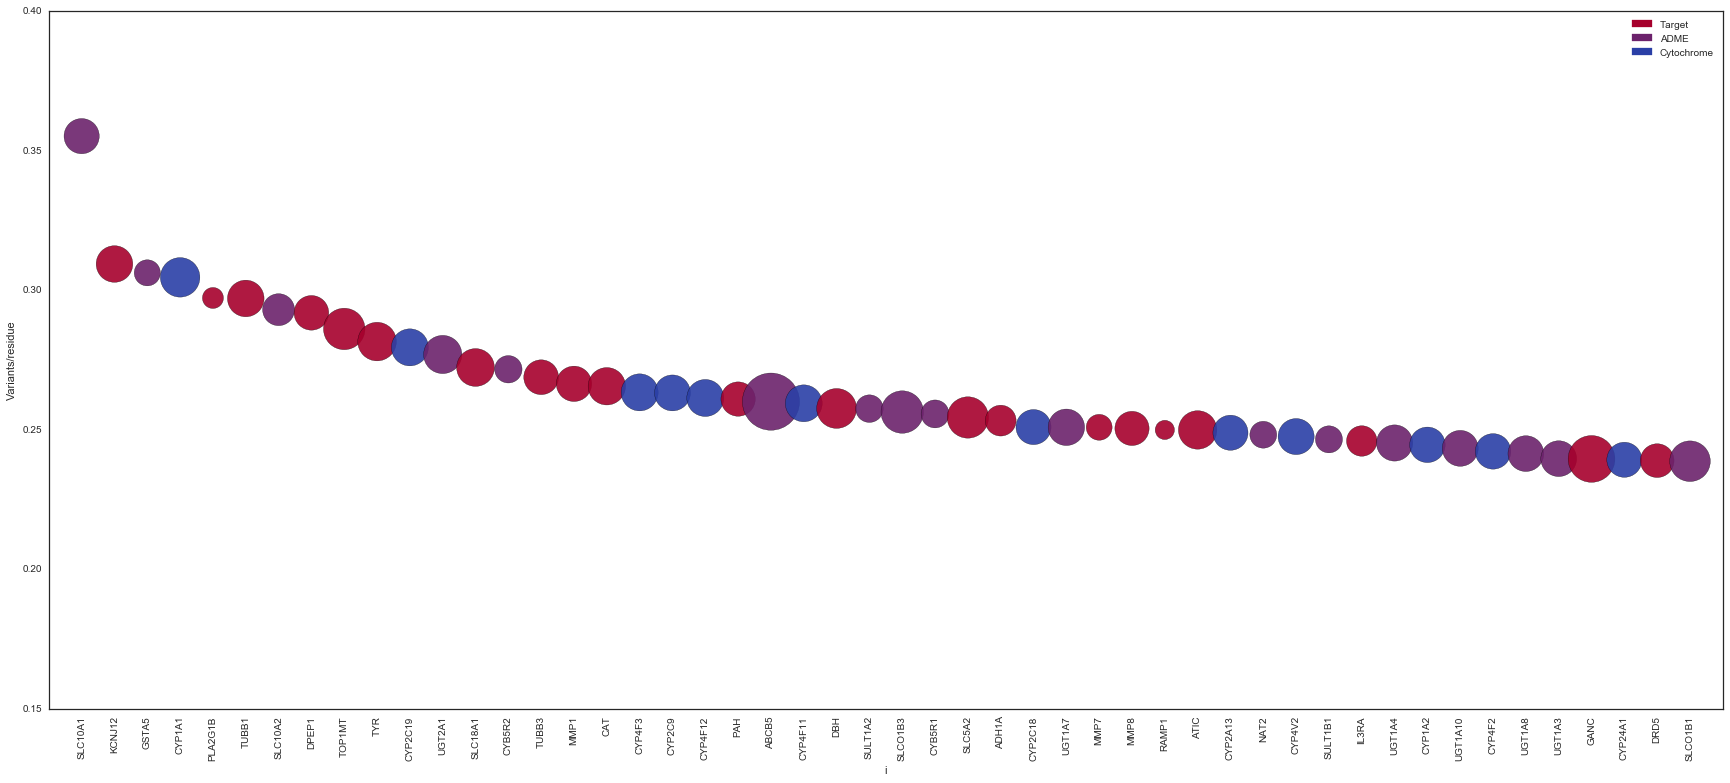

In [86]:
with sns.axes_style("white"):
    subset_all = all_groups_prob_lof.loc[all_groups_prob_lof["group"] != "All genes"].sort_values(by=["normalized_unique_variants"], ascending=False)[:50]
    subset_all.loc[:, 'i'] = subset_all.reset_index().index

    fig, ax = plt.subplots(1, 1, figsize=(30, 12.5))

    subset_all.plot('i', 'normalized_unique_variants',
                    kind='scatter',
                    marker='o',
                    ax=ax,
                    s=subset_all[('var_uid', 'unique_variants')] * 10,
                    c=[COLOR_MAPPING[x] for x in subset_all[('group')]],
                    alpha=0.9)

    ax.set_xlim(-1, len(subset_all))
    plt.xticks(subset_all['i'],
               [str(i) for i in subset_all[('SYMBOL', '')]],
               rotation='vertical')
    
    t = mpatches.Patch(color="#A6002C", label='Target')
    a = mpatches.Patch(color="#6C226C", label='ADME')
    c = mpatches.Patch(color="#2A3FA6", label='Cytochrome')
    plt.legend(handles=[t, a, c])
    ax.set_ylabel("Variants/residue")
#     sns.despine(top=True, right=True, bottom=True)

In [87]:
all_groups_prob_lof.loc[~all_groups_prob_lof["group"].isin(["All genes"])].sort_values(by=["normalized_unique_variants"], ascending=False)[:10]

,"(SYMBOL, )","(HGNC_ID, )","(var_uid, unique_variants)","(Existing_variation, count)","(Existing_variation, ids)","(Consequence, num_nonsense)","(Consequence, num_missense)","(SIFT, num_tolerated)","(SIFT, num_missing)","(SIFT, num_deleterious)",...,"(COMP.AF_NFE, common)","(COMP.AF_FIN, very_rare)","(COMP.AF_FIN, common)",symbol,length,normalized_unique_variants,percent_common,percent_very_rare,group,frac_novel
73,SLC10A1,10905,124,50,"rs149272163,rs144422250,rs371490029,rs18931377...",42,82,0,40,84,...,0.0,124.0,0.0,SLC10A1,349.0,0.355301,0.008065,0.991935,other ADME genes,0.596774
338,KCNJ12,6258,134,43,"rs144702327,rs200772314,rs3752032,COSM1710027,...",8,126,0,8,126,...,2.0,133.0,1.0,KCNJ12,433.0,0.309469,0.029851,0.970149,Target genes,0.679104
43,GSTA5,19662,68,13,"rs147886318,rs200429321,TMP_ESP_6_52701112_527...",19,49,0,18,50,...,3.0,68.0,0.0,GSTA5,222.0,0.306306,0.029412,0.970588,other ADME genes,0.808824
5,CYP1A1,2595,156,57,"TMP_ESP_15_75012937_75012937,TMP_ESP_15_750129...",26,130,0,26,130,...,4.0,155.0,1.0,CYP1A1,512.0,0.304688,0.038462,0.961538,Cytochrome P450s,0.634615
449,PLA2G1B,9030,44,9,"TMP_ESP_12_120760110_120760111,rs140912639,rs3...",17,27,0,17,27,...,0.0,44.0,0.0,PLA2G1B,148.0,0.297297,0.022727,0.977273,Target genes,0.795455
609,TUBB1,16257,134,48,"rs372018486,rs376073390,rs35989782,rs199948010...",20,114,0,19,115,...,5.0,131.0,3.0,TUBB1,451.0,0.297118,0.037313,0.962687,Target genes,0.641791
74,SLC10A2,10906,102,45,"rs201240195,rs141838179,rs150229163&COSM79051,...",23,79,0,23,79,...,3.0,101.0,1.0,SLC10A2,348.0,0.293103,0.029412,0.970588,other ADME genes,0.558824
150,DPEP1,3002,120,40,"rs150374214,rs199523301,rs200857045,rs20126368...",20,100,0,20,100,...,0.0,119.0,1.0,DPEP1,411.0,0.291971,0.008333,0.991667,Target genes,0.666667
593,TOP1MT,29787,172,50,"rs149953316,rs200038590&COSM205607,COSM122104,...",40,132,0,40,132,...,1.0,171.0,1.0,TOP1MT,601.0,0.286190,0.023256,0.976744,Target genes,0.709302
617,TYR,12442,149,95,"CM033045,CM057511,rs61753254&RISN_TYR:c.336_33...",40,109,0,39,110,...,2.0,146.0,3.0,TYR,529.0,0.281664,0.020134,0.979866,Target genes,0.362416


# Variants in different ethnic groups

In [88]:
def calculate_population_overlap(variants,
                                 gene_subset,
                                 populations=POPS,
                                 adjusted_counts="Adj",
                                 af_col_prefix='COMP.AF_',
                                 af_threshold=0.01):
    """Note that if pseudocounts are added some data sets always have at least one observation added to each population"""
    variants_subset = variants.loc[variants.SYMBOL.isin(gene_subset)]
    variants_above_af = variants_subset.loc[variants_subset[af_col_prefix + adjusted_counts] > af_threshold]
    print "{} variants above AF threshold ({}) in total population".format(len(variants_above_af),
                                                                                         af_threshold)
    pop_variants_above_af = {}
    for p in sorted(populations):
        pop_variants_above_af[p] = variants_subset.loc[variants_subset[af_col_prefix + p] > af_threshold]
        print "{} variants above AF threshold ({}) in {}".format(len(pop_variants_above_af[p]),
                                                                               af_threshold, p)
    i_pop_variants = sorted(pop_variants_above_af.items())
    overlap = np.zeros((len(i_pop_variants), len(i_pop_variants)))

    for i, (p, g) in enumerate(i_pop_variants[:-1]):
        overlap[i, i] = len(set(g.var_uid.tolist()))
        all_others = []
        for j, (q, h) in enumerate(i_pop_variants[i + 1:]):
            print 'overlap', p, q, len(set(g.var_uid.tolist()) & set(h.var_uid.tolist()))
            overlap[i, i+j+1] = len(set(g.var_uid.tolist()) & set(h.var_uid.tolist()))
            overlap[i+j+1, i] = len(set(g.var_uid.tolist()) & set(h.var_uid.tolist()))
        

    # handle last population
    overlap[len(i_pop_variants) - 1, len(i_pop_variants) - 1] = len(set(pop_variants_above_af[i_pop_variants[-1][0]].var_uid.tolist()))
    
    # calculate number of unique snps in each population
    unique = {}
    for (p, g) in pop_variants_above_af.items():
        all_others = [set(h.var_uid.tolist()) for q, h in pop_variants_above_af.items() if q != p]
        u = set(g.var_uid.tolist()) - set.union(*all_others)
        a = set(g.var_uid.tolist())
        unique[p] = (len(u) / float(len(a)), len(u))
    
    print len(set.intersection(*[set(y.var_uid.tolist()) for (x, y) in i_pop_variants])),\
        "variants above AF threshold ({}) overlap in all populations.".format(af_threshold)
    
    cols = [x for (x, y) in i_pop_variants]
    return overlap, cols, unique

## Unique functional-variants

In [89]:
overlap, c, all_unique = calculate_population_overlap(probably_lof, pharmacogenes_df.symbol.unique(),
                                                      af_threshold=0.0)

61134 variants above AF threshold (0.0) in total population
10266 variants above AF threshold (0.0) in AFR
9632 variants above AF threshold (0.0) in AMR
8131 variants above AF threshold (0.0) in EAS
2539 variants above AF threshold (0.0) in FIN
34265 variants above AF threshold (0.0) in NFE
14111 variants above AF threshold (0.0) in SAS
overlap AFR AMR 2175
overlap AFR EAS 1020
overlap AFR FIN 749
overlap AFR NFE 3792
overlap AFR SAS 1918
overlap AMR EAS 999
overlap AMR FIN 759
overlap AMR NFE 3969
overlap AMR SAS 2075
overlap EAS FIN 369
overlap EAS NFE 2147
overlap EAS SAS 1370
overlap FIN NFE 1623
overlap FIN SAS 716
overlap NFE SAS 4234
192 variants above AF threshold (0.0) overlap in all populations.


In [90]:
all_unique = pd.DataFrame(all_unique, index=['perc', 'unique_count']).T
all_unique

,perc,unique_count
AFR,0.523963,5379.0
AMR,0.475914,4584.0
EAS,0.630796,5129.0
FIN,0.313509,796.0
NFE,0.719335,24648.0
SAS,0.614273,8668.0


In [91]:
all_unique.perc.mean(), all_unique.perc.std()

(0.5462980572076183, 0.1423695890585503)

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


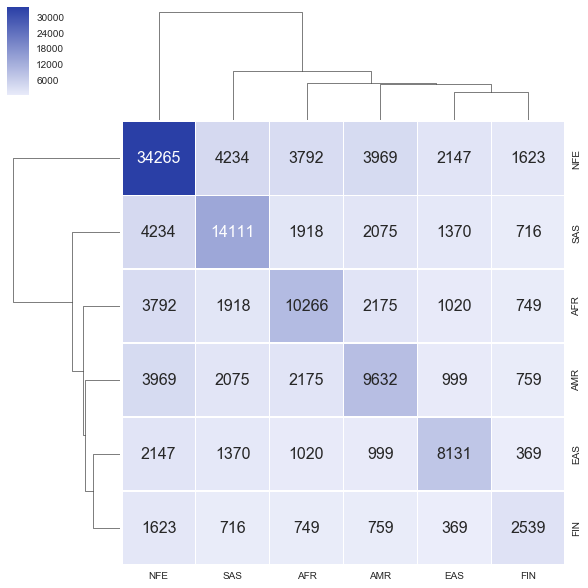

In [92]:
cmap = sns.light_palette("#2A3FA6", as_cmap=True)
ax = sns.clustermap(overlap, linewidths=.5, xticklabels=c, yticklabels=c, annot=True, fmt=".0f",
                    cmap=cmap, annot_kws={"size":16})
plt.savefig(RAW_FIGURE_PATH + "fig3_heatmap_shared_all.pdf",
            dpi=300)

##  Functional-variants that are common in individual or multiple populations

In [93]:
ol, c, unique_common = calculate_population_overlap(probably_lof, pharmacogenes_df.symbol.tolist(),
                                                    af_threshold=0.001)

778 variants above AF threshold (0.001) in total population
903 variants above AF threshold (0.001) in AFR
670 variants above AF threshold (0.001) in AMR
651 variants above AF threshold (0.001) in EAS
539 variants above AF threshold (0.001) in FIN
592 variants above AF threshold (0.001) in NFE
725 variants above AF threshold (0.001) in SAS
overlap AFR AMR 324
overlap AFR EAS 99
overlap AFR FIN 218
overlap AFR NFE 247
overlap AFR SAS 215
overlap AMR EAS 109
overlap AMR FIN 249
overlap AMR NFE 334
overlap AMR SAS 241
overlap EAS FIN 96
overlap EAS NFE 96
overlap EAS SAS 108
overlap FIN NFE 349
overlap FIN SAS 221
overlap NFE SAS 281
76 variants above AF threshold (0.001) overlap in all populations.


In [94]:
unique_common = pd.DataFrame(unique_common, index=['perc', 'unique_count']).T
unique_common

,perc,unique_count
AFR,0.605759,547.0
AMR,0.331343,222.0
EAS,0.768049,500.0
FIN,0.324675,175.0
NFE,0.204392,121.0
SAS,0.560000,406.0


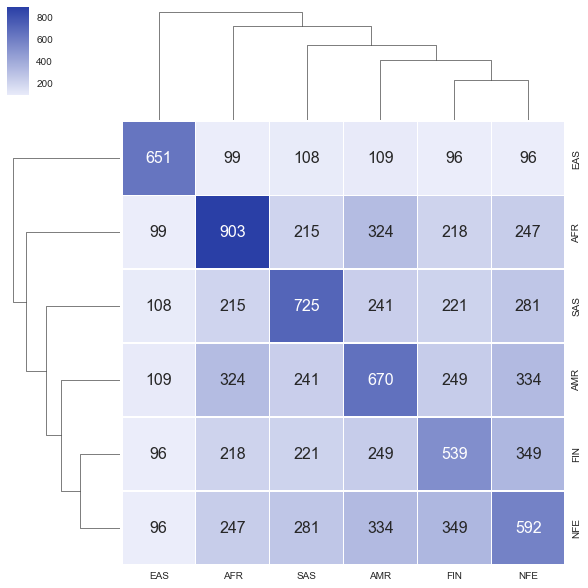

In [95]:
cmap = sns.light_palette("#2A3FA6", as_cmap=True)
ax = sns.clustermap(ol, linewidths=.5, xticklabels=c, yticklabels=c, annot=True, fmt=".0f",
                    cmap=cmap, annot_kws={"size":16})
plt.savefig(RAW_FIGURE_PATH + "fig3_heatmap_shared_common.pdf",
            dpi=300)

# Correlation of Allele Frequencies by gene
This is done to see which genes have very different prominent variants for populations (i.e. one var may be rather common in one, but rare in the other population while this other population has another frequent variant allele in this gene

In [96]:
pop_corr = variants_pharmacogenes[['symbol'] + ["COMP.AF_" + p for p in POPS]]\
    .groupby("symbol")\
    .corr()\
    .reset_index()\
    .dropna(subset=["COMP.AF_" + p for p in POPS], how='all')

In [97]:
pop_corr["max_r"] = pop_corr[[c for c in pop_corr.columns if c.startswith("COMP")]].apply(lambda x: max(c for c in x if c < 1.), axis=1)
pop_corr["min_r"] = pop_corr[[c for c in pop_corr.columns if c.startswith("COMP")]].apply(min, axis=1)

In [98]:
pop_corr.groupby(["symbol"]).agg({"max_r": min, "min_r": min}).corr()

,max_r,min_r
max_r,1.000000,0.931118
min_r,0.931118,1.000000


In [99]:
gene_pop_corr = pop_corr.groupby(["symbol"]).agg({"max_r": min, "min_r": min}).sort_values(by=["min_r"])
pharmacogenes_df.merge(pop_corr, on="symbol")\
    .merge(gene_pop_corr.reset_index(), on="symbol", suffixes=["_pop", "_total"])\
    .sort_values(by=["max_r_total", "symbol"])\
    .head()

,hgnc_id,symbol,uniprot_ids,length,group,subgroup,level_1,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_SAS,max_r_pop,min_r_pop,max_r_total,min_r_total
2710,7170,MMP23A,O75900,390.0,target,target,COMP.AF_AFR,1.000000,-0.333333,-0.333333,NaN,-0.333333,NaN,-0.333333,-0.333333,-0.333333,-0.333333
2711,7170,MMP23A,O75900,390.0,target,target,COMP.AF_AMR,-0.333333,1.000000,-0.333333,NaN,-0.333333,NaN,-0.333333,-0.333333,-0.333333,-0.333333
2712,7170,MMP23A,O75900,390.0,target,target,COMP.AF_EAS,-0.333333,-0.333333,1.000000,NaN,-0.333333,NaN,-0.333333,-0.333333,-0.333333,-0.333333
2713,7170,MMP23A,O75900,390.0,target,target,COMP.AF_NFE,-0.333333,-0.333333,-0.333333,NaN,1.000000,NaN,-0.333333,-0.333333,-0.333333,-0.333333
4760,21492,VKORC1L1,Q8N0U8,176.0,target,target,COMP.AF_AFR,1.000000,0.710902,-0.065857,-0.025093,-0.082323,-0.0399,0.710902,-0.082323,-0.063157,-0.170649


# Exports

In [100]:
variants.to_csv(SUPPLEMENT_PATH + "variants_for_paper.txt", sep="\t", index=False)

In [101]:
supplementary_gene_hotspots.to_csv(SUPPLEMENT_PATH + "supplementary_table_gene_hotspot.tsv", sep="\t", index=False)

In [102]:
probably_lof_variants_pharmacogenes.to_csv(SUPPLEMENT_PATH + "ns_functional_variants_pharmacogenes.txt",
                                           sep="\t", index=False)

In [105]:
probably_lof_by_gene.to_csv(SUPPLEMENT_PATH + "functional_variants_by_gene.txt",
                                           sep="\t", index=False)